
<div style="text-align:center; font-size:32px;">
XGB_boost Model
</div>

---

### Import necessary librairies

In [185]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,root_mean_squared_error
from xgboost import XGBRegressor

In [186]:
#parameters of forecast
date_end_real_data = '2025-11'    #to change
date_debut_forecast = '2025-12'  #to change
date_end_forecast = '2026-12'    #to change
n_months_forecast = 12           #to change

## Data prep
---

In [187]:
# *
# upload the excel file 
df_excel_complete = pd.read_excel('Consolidado_python_Eloi.xlsx')

# convert to CSV so it can be processed in python
df_excel_complete.to_csv('Consolidado_python_Eloi.csv', index=False)

# Visual check of the conversion
df_excel_complete


,Date,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_Rate,Euribor1year
0,201911,NaN,0.80,0.2,6.7,0.35,-0.4013,-0.2720
1,201912,NaN,0.80,0.4,6.8,0.41,-0.3947,-0.2614
2,202001,NaN,-4.20,0.8,6.8,0.37,-0.3911,-0.2534
3,202002,NaN,-4.20,0.5,6.5,0.25,-0.4088,-0.2881
4,202003,NaN,-4.20,0.1,5.8,0.71,-0.4166,-0.2656
...,...,...,...,...,...,...,...,...
93,202708,NaN,2.08,NaN,NaN,NaN,NaN,NaN
94,202709,NaN,2.08,NaN,NaN,NaN,NaN,NaN
95,202710,NaN,2.14,NaN,NaN,NaN,NaN,NaN
96,202711,NaN,2.14,NaN,NaN,NaN,NaN,NaN


In [188]:
# columns of the CSV file 
df_excel_complete.columns

Index(['Date', 'Bananas', 'GDP', 'Inflation', 'Unemployment_Rate',
       'LT_Interest_Rate', 'ST_Interest_Rate', 'Euribor1year'],
      dtype='object')

In [189]:
# Sélections of necessary columns
columns_needed = ['Date',
                  'Bananas',
                  'GDP',
                  'Inflation',
                  'Unemployment_Rate',
                  'LT_Interest_Rate',
                  'ST_Interest_Rate',
                  'Euribor1year']

df_reduced=df_excel_complete[columns_needed]
df_reduced.head()


,Date,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_Rate,Euribor1year
0,201911,NaN,0.8,0.2,6.7,0.35,-0.4013,-0.2720
1,201912,NaN,0.8,0.4,6.8,0.41,-0.3947,-0.2614
2,202001,NaN,-4.2,0.8,6.8,0.37,-0.3911,-0.2534
3,202002,NaN,-4.2,0.5,6.5,0.25,-0.4088,-0.2881
4,202003,NaN,-4.2,0.1,5.8,0.71,-0.4166,-0.2656


In [190]:
# removing the ".0" at the end of the date : 201907.0 otherwise we'll have pb of type
#df_reduced['DATE'] = df_reduced['DATE'].astype(str).str.replace('.0', '', regex=False)
#df_reduced

In [191]:
# Extrqction of year and month (supposing the format is 'YYYYMM')
df_reduced['Date'] = pd.to_datetime(df_reduced['Date'], format='%Y%m')

# put DATE in index
df_reduced = df_reduced.set_index('Date')
df_reduced

,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_Rate,Euribor1year
Date,,,,,,,
2019-11-01,NaN,0.80,0.2,6.7,0.35,-0.4013,-0.2720
2019-12-01,NaN,0.80,0.4,6.8,0.41,-0.3947,-0.2614
2020-01-01,NaN,-4.20,0.8,6.8,0.37,-0.3911,-0.2534
2020-02-01,NaN,-4.20,0.5,6.5,0.25,-0.4088,-0.2881
2020-03-01,NaN,-4.20,0.1,5.8,0.71,-0.4166,-0.2656
...,...,...,...,...,...,...,...
2027-08-01,NaN,2.08,NaN,NaN,NaN,NaN,NaN
2027-09-01,NaN,2.08,NaN,NaN,NaN,NaN,NaN
2027-10-01,NaN,2.14,NaN,NaN,NaN,NaN,NaN


In [192]:
# suppression of the last line which is uncomplete
#df_reduced=df_reduced.iloc[:-1,:]
print(df_reduced.dtypes)

Bananas              float64
GDP                  float64
Inflation            float64
Unemployment_Rate    float64
LT_Interest_Rate     float64
ST_Interest_Rate     float64
Euribor1year         float64
dtype: object


In [193]:
# separation of the real data and the data that is forecast
df_known = df_reduced.loc[:date_end_real_data]                               # to change 

# Conversion of the type of the columns that are not in float
#cols_to_convert = ['Inflation', 'ST_Interest_Rate']              # to change 

#for col in cols_to_convert:
#    df_known[col] = pd.to_numeric(df_known[col], errors='coerce')

# verification of the type
print(df_known.dtypes)

# Séparation train/test on data we know 
train_size = int(len(df_known) * 0.8)
train, test = df_known[:train_size], df_known[train_size:]
train = train.dropna()
# Data to predict 
df_forecast = df_reduced.loc[date_debut_forecast:date_end_forecast]                            # to change 

# Vérification
print(train.shape, test.shape)
print(df_forecast.shape)

Bananas              float64
GDP                  float64
Inflation            float64
Unemployment_Rate    float64
LT_Interest_Rate     float64
ST_Interest_Rate     float64
Euribor1year         float64
dtype: object
(46, 7) (15, 7)
(13, 7)



---


### Feature prep

In [194]:
#define X and Y for the model
features = ['GDP', 'Inflation', 'Unemployment_Rate', 'LT_Interest_Rate', 'ST_Interest_Rate', 'Euribor1year']
X_train = train[features]
y_train = train['Bananas']
X_test = test[features]
y_test = test['Bananas']


In [195]:
X_train

,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_Rate,Euribor1year
Date,,,,,,
2020-11-01,0.2,-0.4,7.2,0.07,-0.5209,-0.4806
2020-12-01,0.2,-0.3,6.9,0.03,-0.5381,-0.4966
2021-01-01,-2.8,0.2,6.9,0.03,-0.5472,-0.5047
2021-02-01,-2.8,0.3,6.8,0.16,-0.5411,-0.5009
2021-03-01,-2.8,0.1,6.7,0.23,-0.5391,-0.4867
2021-04-01,4.6,-0.1,7.2,0.35,-0.5382,-0.4835
2021-05-01,4.6,0.5,7.3,0.53,-0.5401,-0.4806
2021-06-01,4.6,-0.6,7.1,0.43,-0.5429,-0.4839
2021-07-01,3.6,1.1,6.8,0.27,-0.5448,-0.4907


In [196]:
y_train

Date
2020-11-01    0.035473
2020-12-01    0.037405
2021-01-01    0.035782
2021-02-01    0.033814
2021-03-01    0.031089
2021-04-01    0.025261
2021-05-01    0.021414
2021-06-01    0.019845
2021-07-01    0.021488
2021-08-01    0.022337
2021-09-01    0.022674
2021-10-01    0.023827
2021-11-01    0.024668
2021-12-01    0.025587
2022-01-01    0.022777
2022-02-01    0.023074
2022-03-01    0.023487
2022-04-01    0.026882
2022-05-01    0.027910
2022-06-01    0.029487
2022-07-01    0.030301
2022-08-01    0.034625
2022-09-01    0.035556
2022-10-01    0.038039
2022-11-01    0.042859
2022-12-01    0.047126
2023-01-01    0.049350
2023-02-01    0.054083
2023-03-01    0.059178
2023-04-01    0.064044
2023-05-01    0.066951
2023-06-01    0.069564
2023-07-01    0.071845
2023-08-01    0.074210
2023-09-01    0.072171
2023-10-01    0.073208
2023-11-01    0.071678
2023-12-01    0.069690
2024-01-01    0.055859
2024-02-01    0.050661
2024-03-01    0.051283
2024-04-01    0.048583
2024-05-01    0.046140
2024-0

## Final version of XGB_boost with K-fold, lags and itératives predictions

---

In [197]:
df_known.tail(50)

,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_Rate,Euribor1year
Date,,,,,,,
2021-10-01,0.023827,1.90,1.8,6.400000,0.39,-0.5498,-0.4768
2021-11-01,0.024668,1.90,2.6,6.300000,0.39,-0.5674,-0.4870
2021-12-01,0.025587,1.90,2.8,5.900000,0.36,-0.5820,-0.5020
2022-01-01,0.022777,1.70,3.4,5.900000,0.58,-0.5601,-0.4767
2022-02-01,0.023074,1.70,4.4,5.700000,1.06,-0.5315,-0.3353
2022-03-01,0.023487,1.70,5.5,5.900000,1.16,-0.4954,-0.2374
2022-04-01,0.026882,0.40,7.4,6.100000,1.76,-0.4479,0.0131
2022-05-01,0.027910,0.40,8.1,6.300000,2.14,-0.3857,0.2866
2022-06-01,0.029487,0.40,9.0,6.200000,2.65,-0.2392,0.8522


In [198]:
y_all.tail(10)

Date
2025-02-01    0.037974
2025-03-01    0.033439
2025-04-01    0.036098
2025-05-01    0.038396
2025-06-01    0.034455
2025-07-01    0.035599
2025-08-01    0.036360
2025-09-01    0.036490
2025-10-01    0.038588
2025-11-01    0.038588
Name: Bananas, dtype: float64

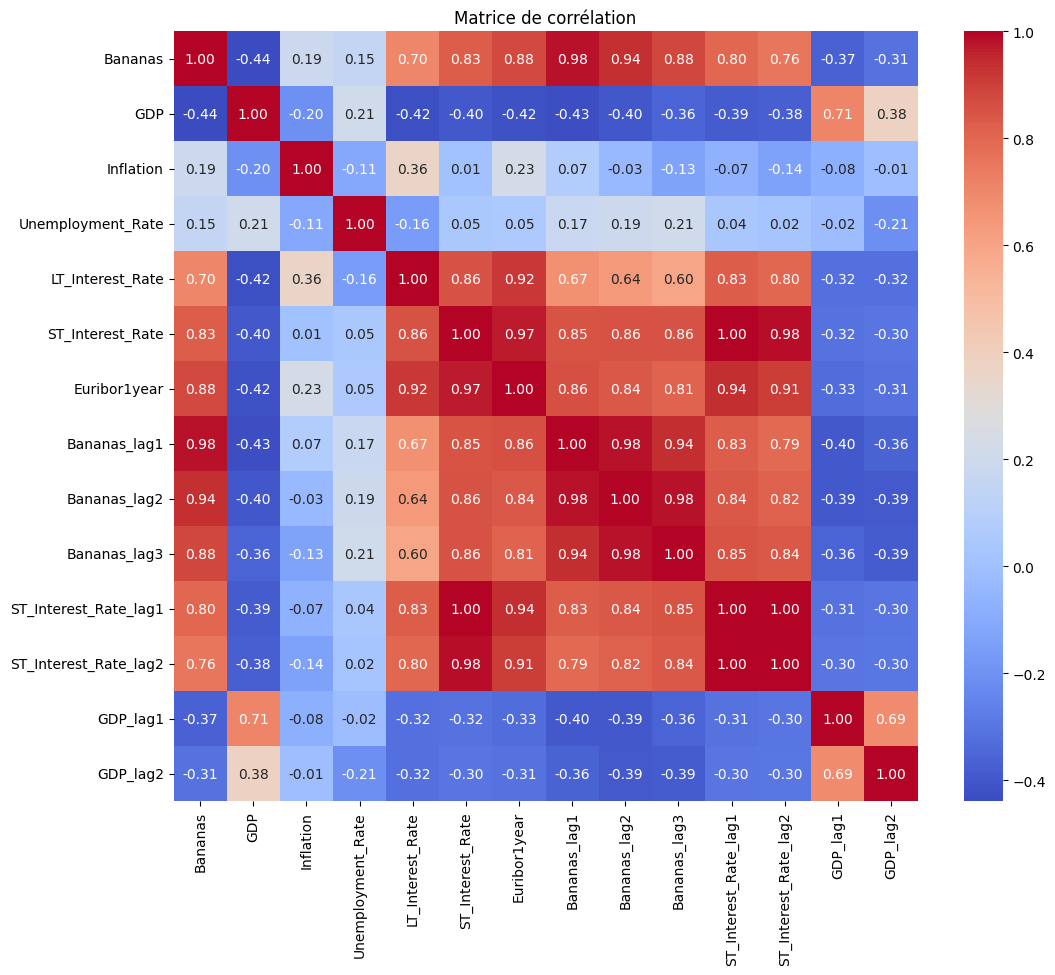

Fold 1 RMSE: 0.00540
Fold 2 RMSE: 0.00355
Fold 3 RMSE: 0.00408
Fold 4 RMSE: 0.00467
Fold 5 RMSE: 0.00294


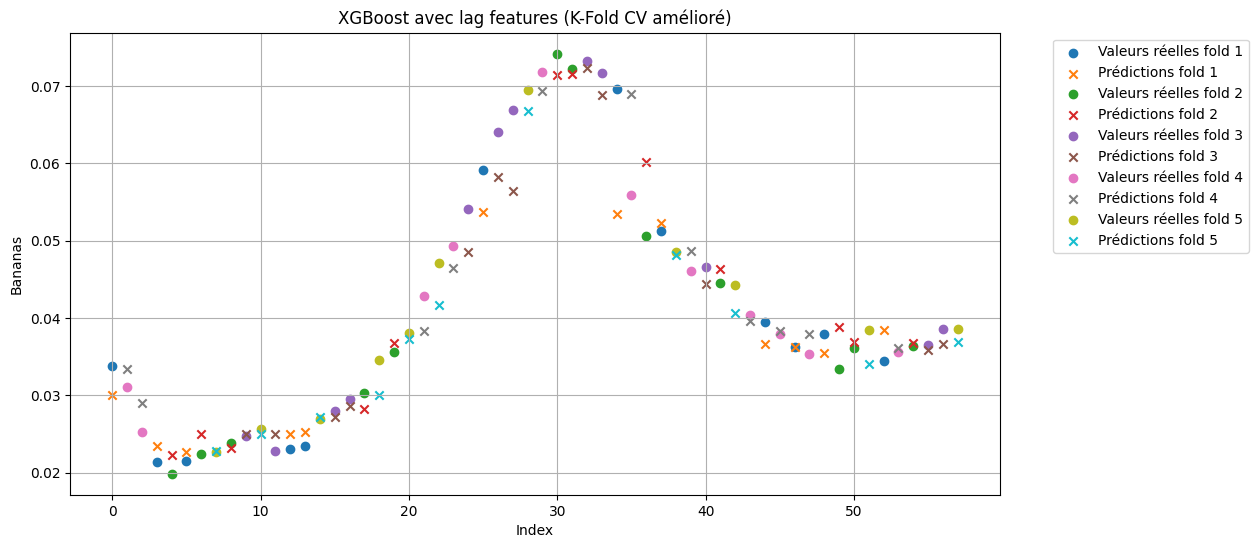

RMSE moyen sur tous les folds: 0.00413


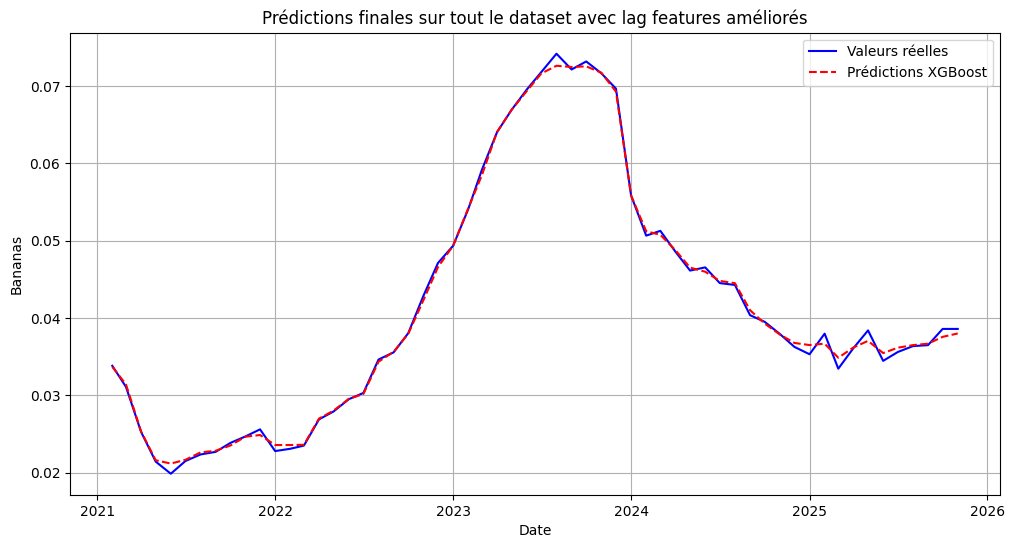

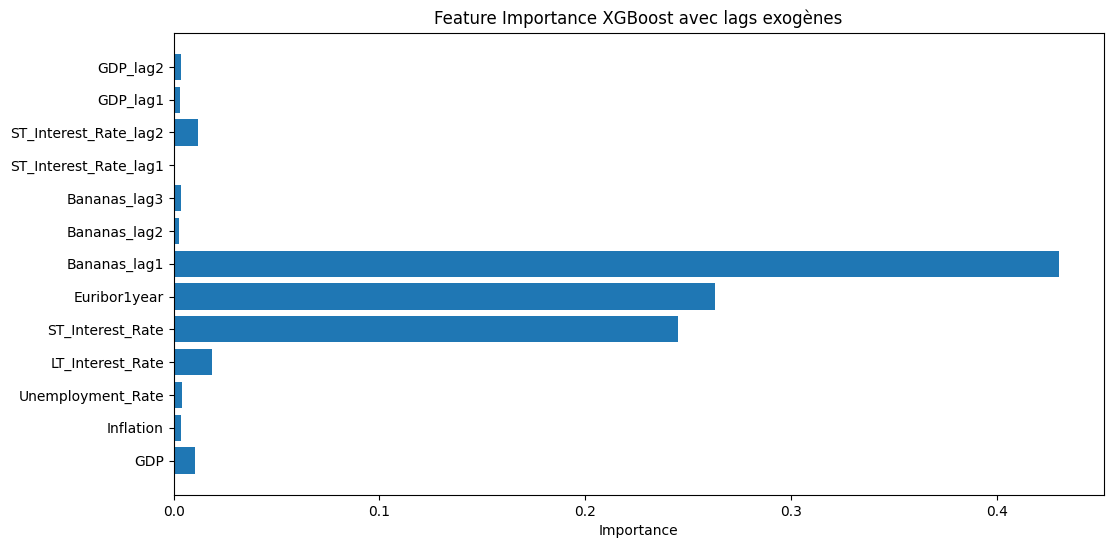

In [199]:
#meilleur modele xgboost avec lag et k-fold 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns

# --- 1. Function to create lags ---
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog={}):
    """
    df : dataframe
    target_col : colonne cible (Bananas)
    lags_target : lags sur la target
    lags_exog : dict {feature_name: [list_of_lags]}
    """
    df_lag = df.copy()
    
    # Lags on target
    for lag in lags_target:
        df_lag[f'{target_col}_lag{lag}'] = df_lag[target_col].shift(lag)
    
    # Lags on features
    for feature, lags in lags_exog.items():
        for lag in lags:
            df_lag[f'{feature}_lag{lag}'] = df_lag[feature].shift(lag)
    
    df_lag = df_lag.dropna()
    return df_lag

# Lags
lags_target = [1,2,3]
lags_exog = {
    'ST_Interest_Rate': [1,2],
    'GDP': [1,2]
}

df_lag = create_lag_features(df_known, 'Bananas', lags_target=lags_target, lags_exog=lags_exog)

# --- 2. correlation matrix ---
plt.figure(figsize=(12,10))
sns.heatmap(df_lag.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

# --- 3. Définir features and target ---
features = ['GDP', 'Inflation', 'Unemployment_Rate', 
            'LT_Interest_Rate', 'ST_Interest_Rate', 'Euribor1year'] + \
           [f'Bananas_lag{lag}' for lag in lags_target] + \
           [f'{feat}_lag{lag}' for feat, lags in lags_exog.items() for lag in lags]

X_all = df_lag[features]
y_all = df_lag['Bananas']

# --- 4. K-Fold Cross-Validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_folds = []

plt.figure(figsize=(12,6))
for i, (train_index, val_index) in enumerate(kf.split(X_all)):
    X_tr, X_val = X_all.iloc[train_index], X_all.iloc[val_index]
    y_tr, y_val = y_all.iloc[train_index], y_all.iloc[val_index]
    
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_tr, y_tr)
    
    y_pred_fold = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_fold))
    rmse_folds.append(rmse)
    
    # Plot of prédictions vs real
    plt.scatter(val_index, y_val, label=f'Valeurs réelles fold {i+1}', marker='o')
    plt.scatter(val_index, y_pred_fold, label=f'Prédictions fold {i+1}', marker='x')
    
    print(f"Fold {i+1} RMSE: {rmse:.5f}")

plt.xlabel('Index')
plt.ylabel('Bananas')
plt.title('XGBoost avec lag features (K-Fold CV amélioré)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

print(f"RMSE moyen sur tous les folds: {np.mean(rmse_folds):.5f}")

# --- 5. final training on all the data ---
model_final = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
model_final.fit(X_all, y_all)

y_pred_all = model_final.predict(X_all)

plt.figure(figsize=(12,6))
plt.plot(df_lag.index, y_all.values, label='Valeurs réelles', color='blue')
plt.plot(df_lag.index, y_pred_all, label='Prédictions XGBoost', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Bananas')
plt.title('Prédictions finales sur tout le dataset avec lag features améliorés')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Feature importance ---
importances = model_final.feature_importances_
plt.figure(figsize=(12,6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Feature Importance XGBoost avec lags exogènes")
plt.show()


### Code to apply the model for our forecast of 2026

RMSE (train): 0.0004752644793855718

Prévisions Bananas 2025-12 → 2026-12 :


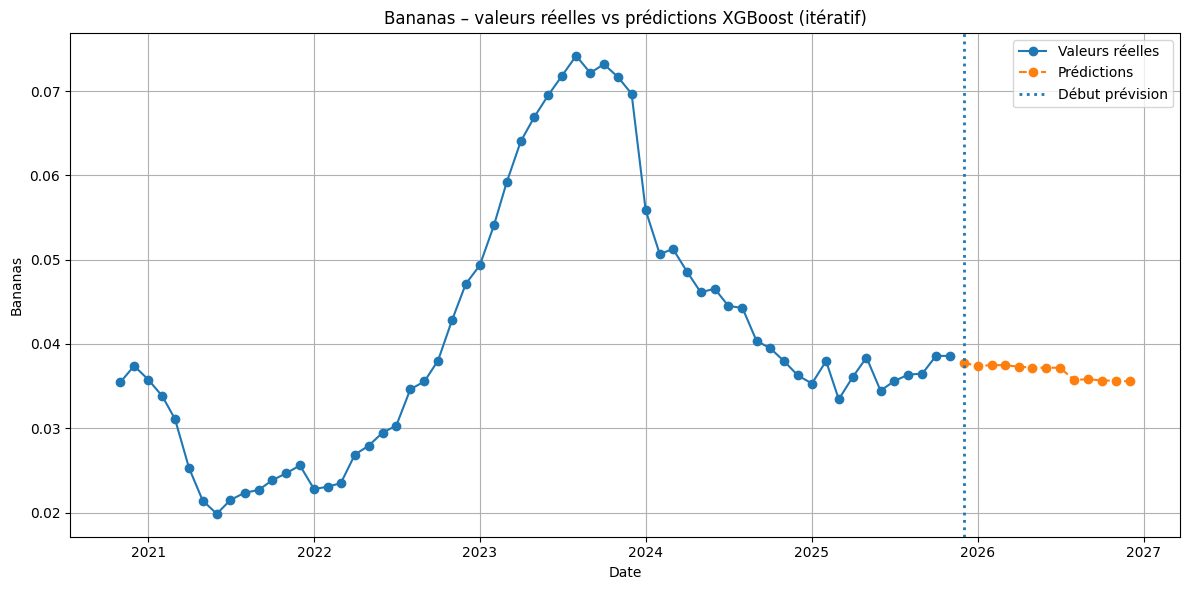

In [200]:
#meilleurs resultats en XGBOOST et réalisation -> version itérative mais sans k-fold
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1. Concaténer historique et futur
df_full = pd.concat([df_known, df_forecast])
df_full = df_full.sort_index()

# 2. Créer les lags
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog=[1]):
    df_lagged = df.copy()
    # Lags de la variable cible
    for lag in lags_target:
        df_lagged[f"{target_col}_lag{lag}"] = df_lagged[target_col].shift(lag)
    # Lags pour les variables exogènes
    for col in df.columns:
        if col != target_col:
            for lag in lags_exog:
                df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    return df_lagged

lags_target = [1,2,3]
lags_exog = [1]

df_full_lag = create_lag_features(df_full, "Bananas", lags_target, lags_exog)

# 3. Séparer historique et futur
df_train_lag = df_full_lag.loc[df_full_lag.index].dropna()

X_train = df_train_lag.drop(columns=["Bananas"])
y_train = df_train_lag["Bananas"]

# Entraînement du modèle
model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# Erreur sur l’historique
y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE (train):", rmse_train)

# 4. Prédictions itératives sur le futur
df_future_preds = df_full_lag.loc[df_forecast.index].copy()
features = X_train.columns  # mêmes features qu’au training
y_pred_future = []

for date in df_future_preds.index:
    # Features du mois t
    X_t = df_future_preds.loc[date, features].values.reshape(1, -1)
    # Prédiction Bananas_t
    y_t = model.predict(X_t)[0]
    df_future_preds.loc[date, "Bananas_pred"] = y_t
    y_pred_future.append(y_t)
    
    # Mise à jour des lags pour le mois suivant
    next_idx = df_future_preds.index.get_loc(date) + 1
    if next_idx < len(df_future_preds):
        next_date = df_future_preds.index[next_idx]
        df_future_preds.loc[next_date, "Bananas_lag1"] = y_t
        df_future_preds.loc[next_date, "Bananas_lag2"] = df_future_preds.loc[date, "Bananas_lag1"]
        df_future_preds.loc[next_date, "Bananas_lag3"] = df_future_preds.loc[date, "Bananas_lag2"]
df_future_preds
# Résultat final
print("\nPrévisions Bananas 2025-12 → 2026-12 :")
#print(df_future_preds[["Bananas_pred"]])
df_future_preds

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Valeurs réelles (historique)
plt.plot(
    df_known.index,
    df_known["Bananas"],
    label="Valeurs réelles",
    marker="o"
)

# Prédictions futures
plt.plot(
    df_future_preds.index,
    df_future_preds["Bananas_pred"],
    label="Prédictions",
    marker="o",
    linestyle="--"
)

# Ligne verticale pour séparer train / forecast
plt.axvline(
    x=df_forecast.index[0],
    linestyle=":",
    linewidth=2,
    label="Début prévision"
)

plt.title("Bananas – valeurs réelles vs prédictions XGBoost (itératif)")
plt.xlabel("Date")
plt.ylabel("Bananas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [201]:
df_future_preds

,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_Rate,Euribor1year,Bananas_lag1,Bananas_lag2,Bananas_lag3,GDP_lag1,Inflation_lag1,Unemployment_Rate_lag1,LT_Interest_Rate_lag1,ST_Interest_Rate_lag1,Euribor1year_lag1,Bananas_pred
Date,,,,,,,,,,,,,,,,,
2025-12-01,NaN,1.78,2.20,6.209587,3.22,2.423615,2.227,0.038588,0.038588,0.036490,1.78,2.00,6.209587,3.03,2.040000,2.199,0.037768
2026-01-01,NaN,1.69,2.45,6.400000,3.10,3.050000,2.249,0.037768,0.038588,0.038588,1.78,2.20,6.209587,3.22,2.423615,2.227,0.037393
2026-02-01,NaN,1.69,2.30,6.880000,3.10,3.050000,2.252,0.037393,0.037768,0.038588,1.69,2.45,6.400000,3.10,3.050000,2.249,0.037489
2026-03-01,NaN,1.69,2.15,6.660000,3.10,3.050000,2.265,0.037489,0.037393,0.037768,1.69,2.30,6.880000,3.10,3.050000,2.252,0.037489
2026-04-01,NaN,1.59,2.05,6.540000,3.00,2.950000,2.268,0.037489,0.037489,0.037393,1.69,2.15,6.660000,3.10,3.050000,2.265,0.037311
2026-05-01,NaN,1.59,1.90,6.420000,3.00,2.950000,2.347,0.037311,0.037489,0.037489,1.59,2.05,6.540000,3.00,2.950000,2.268,0.037183
2026-06-01,NaN,1.59,1.80,6.200000,3.00,2.950000,2.339,0.037183,0.037311,0.037489,1.59,1.90,6.420000,3.00,2.950000,2.347,0.037183
2026-07-01,NaN,1.92,1.75,6.080000,2.90,2.850000,2.324,0.037183,0.037183,0.037311,1.59,1.80,6.200000,3.00,2.950000,2.339,0.037183
2026-08-01,NaN,1.92,1.80,6.160000,2.90,2.850000,2.304,0.037183,0.037183,0.037183,1.92,1.75,6.080000,2.90,2.850000,2.324,0.035728


Fold 1 RMSE: 0.0041
Fold 2 RMSE: 0.0031
Fold 3 RMSE: 0.0044
Fold 4 RMSE: 0.0040
Fold 5 RMSE: 0.0031

RMSE moyen (CV): 0.0037356366297352896
RMSE (train complet): 0.0013620718428765367

Prévisions Bananas 2025-08 → 2026-12 :
            Bananas_pred
Date                    
2025-12-01      0.037342
2026-01-01      0.037065
2026-02-01      0.037151
2026-03-01      0.037142
2026-04-01      0.037194
2026-05-01      0.036951
2026-06-01      0.036919
2026-07-01      0.036827
2026-08-01      0.036705
2026-09-01      0.036848
2026-10-01      0.036984
2026-11-01      0.036923
2026-12-01      0.036625


/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegress

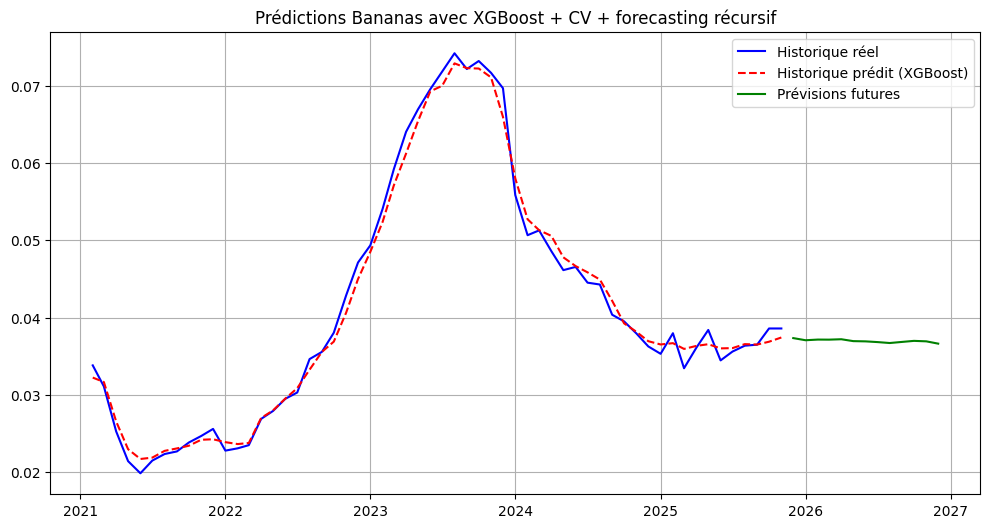

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [202]:
# --- Imports ---, version avec k-fold cross validation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# --- 1. Concaténer historique et futur ---
df_full = pd.concat([df_known, df_forecast])
df_full = df_full.sort_index()

# --- 2. Créer les lags ---
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog=[1]):
    df_lagged = df.copy()
    # Lags de la variable cible
    for lag in lags_target:
        df_lagged[f"{target_col}_lag{lag}"] = df_lagged[target_col].shift(lag)
    # Lags des exogènes
    for col in df.columns:
        if col != target_col:
            for lag in lags_exog:
                df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    return df_lagged

lags_target = [1,2,3]
lags_exog = [1]

df_full_lag = create_lag_features(df_full, "Bananas", lags_target, lags_exog)

# --- 3. Séparer historique (train) et futur ---
df_train_lag = df_full_lag.loc[df_known.index].dropna()

X_train = df_train_lag.drop(columns=["Bananas"])
y_train = df_train_lag["Bananas"]

# --- 4. Validation croisée K-Fold ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_folds = []

for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model_cv = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=4)  # Modèle XGBoost
    model_cv.fit(X_tr, y_tr)
    
    y_val_pred = model_cv.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    rmse_folds.append(rmse)
    print(f"Fold {i+1} RMSE: {rmse:.4f}")

print("\nRMSE moyen (CV):", np.mean(rmse_folds))

# --- 5. Entraînement final sur tout l’historique ---
model_final = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=4)  # Modèle XGBoost
model_final.fit(X_train, y_train)

# Erreur sur train complet
y_train_pred = model_final.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE (train complet):", rmse_train)

# --- 6. Prédictions itératives sur le futur (corrigé) ---
df_future_preds = df_full_lag.loc[df_forecast.index].copy()
features = X_train.columns
y_pred_future = []

# 1️⃣ Initialiser les lags du premier mois du futur avec les dernières valeurs réelles
first_future = df_future_preds.index[0]

df_future_preds.loc[first_future, "Bananas_lag1"] = df_full_lag.loc[df_known.index[-1], "Bananas"]
df_future_preds.loc[first_future, "Bananas_lag2"] = df_full_lag.loc[df_known.index[-2], "Bananas"]
df_future_preds.loc[first_future, "Bananas_lag3"] = df_full_lag.loc[df_known.index[-3], "Bananas"]

# 2️⃣ Boucle récursive pour prédire mois par mois
for date in df_future_preds.index:
    # Features du mois t
    X_t = df_future_preds.loc[date, features].values.reshape(1, -1)
    # Prédiction Bananas_t
    y_t = model_final.predict(X_t)[0]
    df_future_preds.loc[date, "Bananas_pred"] = y_t
    y_pred_future.append(y_t)
    
    # Mise à jour des lags pour le mois suivant
    next_idx = df_future_preds.index.get_loc(date) + 1
    if next_idx < len(df_future_preds):
        next_date = df_future_preds.index[next_idx]
        df_future_preds.loc[next_date, "Bananas_lag1"] = y_t
        df_future_preds.loc[next_date, "Bananas_lag2"] = df_future_preds.loc[date, "Bananas_lag1"]
        df_future_preds.loc[next_date, "Bananas_lag3"] = df_future_preds.loc[date, "Bananas_lag2"]

# --- Résultat final ---
print("\nPrévisions Bananas 2025-08 → 2026-12 :")
print(df_future_preds[["Bananas_pred"]])

# Optionnel : tracé historique vs futur prédit
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_train_lag.index, y_train, label="Historique réel", color="blue")
plt.plot(df_train_lag.index, y_train_pred, label="Historique prédit (XGBoost)", color="red", linestyle="--")
plt.plot(df_future_preds.index, df_future_preds["Bananas_pred"], label="Prévisions futures", color="green")
plt.legend()
plt.grid(True)
plt.title("Prédictions Bananas avec XGBoost + CV + forecasting récursif")
plt.show()
df_future_preds

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))



Fold 1 RMSE: 0.0055
Fold 2 RMSE: 0.0030
Fold 3 RMSE: 0.0044
Fold 4 RMSE: 0.0040
Fold 5 RMSE: 0.0029

RMSE moyen (CV): 0.003966451236941558
RMSE (train complet): 0.0013620718428765367

Prévisions Bananas 2025-08 → 2026-12 :
            Bananas_pred
Date                    
2025-12-01      0.037342
2026-01-01      0.037065
2026-02-01      0.037151
2026-03-01      0.037142
2026-04-01      0.037194
2026-05-01      0.036951
2026-06-01      0.036919
2026-07-01      0.036827
2026-08-01      0.036705
2026-09-01      0.036848
2026-10-01      0.036984
2026-11-01      0.036923
2026-12-01      0.036625


/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegress

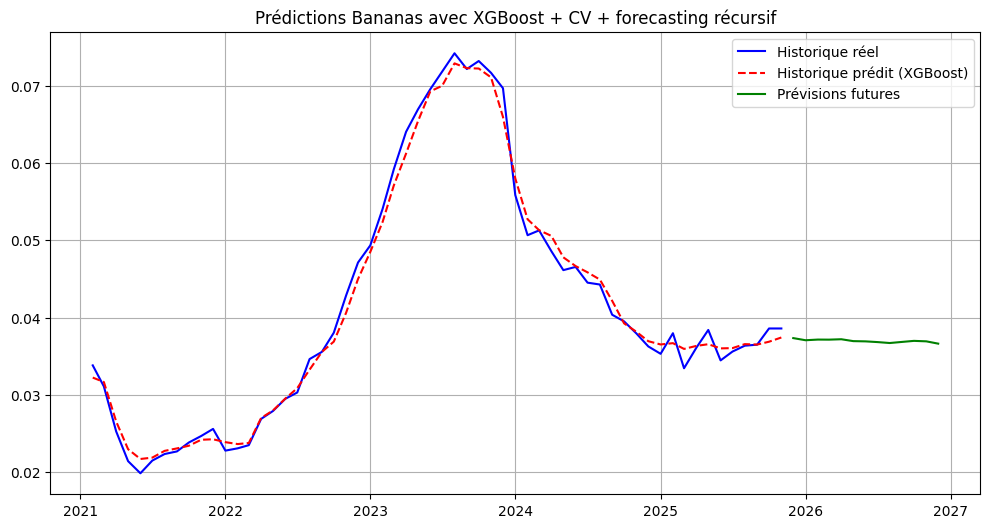

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [203]:
# --- Imports ---, version avec k-fold cross validation en XGBoost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# --- 1. Concaténer historique et futur ---
df_full = pd.concat([df_known, df_forecast])
df_full = df_full.sort_index()

# --- 2. Créer les lags ---
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog=[1]):
    df_lagged = df.copy()
    # Lags de la variable cible
    for lag in lags_target:
        df_lagged[f"{target_col}_lag{lag}"] = df_lagged[target_col].shift(lag)
    # Lags des exogènes
    for col in df.columns:
        if col != target_col:
            for lag in lags_exog:
                df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    return df_lagged

lags_target = [1,2,3]
lags_exog = [1]

df_full_lag = create_lag_features(df_full, "Bananas", lags_target, lags_exog)

# --- 3. Séparer historique (train) et futur ---
df_train_lag = df_full_lag.loc[df_known.index].dropna()

X_train = df_train_lag.drop(columns=["Bananas"])
y_train = df_train_lag["Bananas"]

# --- 4. Validation croisée K-Fold ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_folds = []

for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model_cv = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
    model_cv.fit(X_tr, y_tr)
    
    y_val_pred = model_cv.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    rmse_folds.append(rmse)
    print(f"Fold {i+1} RMSE: {rmse:.4f}")

print("\nRMSE moyen (CV):", np.mean(rmse_folds))

# --- 5. Entraînement final sur tout l’historique ---
model_final = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=4)  # Modèle XGBoost
model_final.fit(X_train, y_train)

# Erreur sur train complet
y_train_pred = model_final.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE (train complet):", rmse_train)

# --- 6. Prédictions itératives sur le futur (corrigé) ---
df_future_preds = df_full_lag.loc[df_forecast.index].copy()
features = X_train.columns
y_pred_future = []

# 1️⃣ Initialiser les lags du premier mois du futur avec les dernières valeurs réelles
first_future = df_future_preds.index[0]

df_future_preds.loc[first_future, "Bananas_lag1"] = df_full_lag.loc[df_known.index[-1], "Bananas"]
df_future_preds.loc[first_future, "Bananas_lag2"] = df_full_lag.loc[df_known.index[-2], "Bananas"]
df_future_preds.loc[first_future, "Bananas_lag3"] = df_full_lag.loc[df_known.index[-3], "Bananas"]

# 2️⃣ Boucle récursive pour prédire mois par mois
for date in df_future_preds.index:
    # Features du mois t
    X_t = df_future_preds.loc[date, features].values.reshape(1, -1)
    # Prédiction Bananas_t
    y_t = model_final.predict(X_t)[0]
    df_future_preds.loc[date, "Bananas_pred"] = y_t
    y_pred_future.append(y_t)
    
    # Mise à jour des lags pour le mois suivant
    next_idx = df_future_preds.index.get_loc(date) + 1
    if next_idx < len(df_future_preds):
        next_date = df_future_preds.index[next_idx]
        df_future_preds.loc[next_date, "Bananas_lag1"] = y_t
        df_future_preds.loc[next_date, "Bananas_lag2"] = df_future_preds.loc[date, "Bananas_lag1"]
        df_future_preds.loc[next_date, "Bananas_lag3"] = df_future_preds.loc[date, "Bananas_lag2"]

# --- Résultat final ---
print("\nPrévisions Bananas 2025-08 → 2026-12 :")
print(df_future_preds[["Bananas_pred"]])

# Optionnel : tracé historique vs futur prédit
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_train_lag.index, y_train, label="Historique réel", color="blue")
plt.plot(df_train_lag.index, y_train_pred, label="Historique prédit (XGBoost)", color="red", linestyle="--")
plt.plot(df_future_preds.index, df_future_preds["Bananas_pred"], label="Prévisions futures", color="green")
plt.legend()
plt.grid(True)
plt.title("Prédictions Bananas avec XGBoost + CV + forecasting récursif")
plt.show()
df_future_preds

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))



In [204]:
df_train_lag

,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_Rate,Euribor1year,Bananas_lag1,Bananas_lag2,Bananas_lag3,GDP_lag1,Inflation_lag1,Unemployment_Rate_lag1,LT_Interest_Rate_lag1,ST_Interest_Rate_lag1,Euribor1year_lag1
Date,,,,,,,,,,,,,,,,
2021-02-01,0.033814,-2.80,0.3,6.800000,0.16,-0.5411,-0.5009,0.035782,0.037405,0.035473,-2.80,0.2,6.9,0.03,-0.5472,-0.5047
2021-03-01,0.031089,-2.80,0.1,6.700000,0.23,-0.5391,-0.4867,0.033814,0.035782,0.037405,-2.80,0.3,6.8,0.16,-0.5411,-0.5009
2021-04-01,0.025261,4.60,-0.1,7.200000,0.35,-0.5382,-0.4835,0.031089,0.033814,0.035782,-2.80,0.1,6.7,0.23,-0.5391,-0.4867
2021-05-01,0.021414,4.60,0.5,7.300000,0.53,-0.5401,-0.4806,0.025261,0.031089,0.033814,4.60,-0.1,7.2,0.35,-0.5382,-0.4835
2021-06-01,0.019845,4.60,-0.6,7.100000,0.43,-0.5429,-0.4839,0.021414,0.025261,0.031089,4.60,0.5,7.3,0.53,-0.5401,-0.4806
2021-07-01,0.021488,3.60,1.1,6.800000,0.27,-0.5448,-0.4907,0.019845,0.021414,0.025261,4.60,-0.6,7.1,0.43,-0.5429,-0.4839
2021-08-01,0.022337,3.60,1.3,6.600000,0.14,-0.5476,-0.4982,0.021488,0.019845,0.021414,3.60,1.1,6.8,0.27,-0.5448,-0.4907
2021-09-01,0.022674,3.60,1.3,6.600000,0.26,-0.5450,-0.4923,0.022337,0.021488,0.019845,3.60,1.3,6.6,0.14,-0.5476,-0.4982
2021-10-01,0.023827,1.90,1.8,6.400000,0.39,-0.5498,-0.4768,0.022674,0.022337,0.021488,3.60,1.3,6.6,0.26,-0.5450,-0.4923


---

---

## Annexe